# **XGBOOST FORECASTING WITH SUPERVISED LEARNING**

In [ ]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

## **Transform a time series dataset into a supervised learning dataset**


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

## **FITTING OF MODEL**

In [ ]:


# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]



## **PREDICTION AND ERROR CALCULATION**

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


>expected=1.2, predicted=1.5
>expected=1.2, predicted=1.5
>expected=1.2, predicted=1.5
>expected=1.2, predicted=1.5
>expected=1.2, predicted=1.5
>expected=1.2, predicted=1.5
>expected=1.2, predicted=1.5
>expected=1.2, predicted=1.5
>expected=1.2, predicted=1.5
>expected=1.4, predicted=1.5
>expected=1.9, predicted=1.5
>expected=3.0, predicted=2.1
>expected=5.8, predicted=3.2
>expected=7.2, predicted=6.8
>expected=11.0, predicted=8.5
>expected=15.7, predicted=14.9
>expected=19.1, predicted=17.5
>expected=25.7, predicted=20.5
>expected=34.6, predicted=50.2
>expected=38.5, predicted=45.6
>expected=45.2, predicted=46.4
>expected=47.7, predicted=57.2
>expected=58.5, predicted=75.4
>expected=70.5, predicted=79.1
>expected=68.0, predicted=78.3
>expected=74.8, predicted=77.5
>expected=84.7, predicted=81.3
>expected=101.4, predicted=89.6
>expected=106.3, predicted=102.5
>expected=99.4, predicted=111.6
>expected=100.1, predicted=100.9
>expected=121.7, predicted=100.9
>expected=156.5, predicted=12

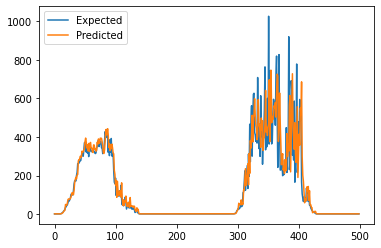

In [ ]:
# load the dataset
series = read_csv('/content/sample_data/SolarPrediction_dataset2.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 500)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()